In [1]:
## Imports
import PlottingEventDisplays
import sys
import os
import time
import math
import random
import pdb
import h5py

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Plotting import
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.colors as colors

# Import the utils for plotting the metrics
from plot_utils import plot_utils
from plot_utils import notebook_utils_2

from sklearn.metrics import roc_curve, auc

# Dictionary mapping the ordinal labels to particle types 
LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}
softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

# Fix the colour scheme for each particle type
COLOR_DICT = {"gamma":"red", "e":"blue", "mu":"green"}

label_0 = "e"
label_1 = "mu"
min_energy = 0
max_energy = 1000

In [2]:
# Get original h5 file info

# Import test events from h5 file
filtered_index = "/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz"
filtered_indices = np.load(filtered_index, allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']
print(test_filtered_indices.shape)

original_data_path = "/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5"
f = h5py.File(original_data_path, "r")

hdf5_event_data = (f["event_data"])
original_eventdata = np.memmap(original_data_path, mode="r", shape=hdf5_event_data.shape,
                                    offset=hdf5_event_data.id.get_offset(), dtype=hdf5_event_data.dtype)

original_eventids = np.array(f['event_ids'])
original_rootfiles = np.array(f['root_files'])
original_energies = np.array(f['energies'])
original_positions = np.array(f['positions'])
original_angles = np.array(f['angles'])
original_labels = np.array(f['labels'])

#filtered_eventdata = original_eventdata[test_filtered_indices]
filtered_eventids = original_eventids[test_filtered_indices]
filtered_rootfiles = original_rootfiles[test_filtered_indices]
filtered_energies = original_energies[test_filtered_indices]
filtered_positions = original_positions[test_filtered_indices]
filtered_angles = original_angles[test_filtered_indices]
filtered_labels = original_labels[test_filtered_indices]


(3351020,)


In [3]:
# Map ResNet results to fiTQun events

# Map ResNet results to original h5 file events
mapping_indices = np.load('/home/ttuinstr/VAE/debugging/map_indices_resnet.npz')
mapping_indices = mapping_indices['arr_0'].astype(int)

res_softmaxes = np.load('/home/ttuinstr/VAE/debugging/resnet_softmaxes.npz')
res_softmaxes = res_softmaxes['arr_0']
res_energies = np.load('/home/ttuinstr/VAE/debugging/resnet_energies.npz')
res_energies = res_energies['arr_0']
res_predictedlabels = np.load('/home/ttuinstr/VAE/debugging/resnet_predictedlabels.npz')
res_predictedlabels = res_predictedlabels['arr_0']

res_softmaxes = res_softmaxes[mapping_indices]
res_energies = res_energies[mapping_indices]
res_predictedlabels = res_predictedlabels[mapping_indices]

# Separate event types
e_test_indices = np.load('/home/ttuinstr/VAE/debugging/test_indices_e.npz')
e_test_indices = e_test_indices['arr_0'].astype(int)
mu_test_indices = np.load('/home/ttuinstr/VAE/debugging/test_indices_mu.npz')
mu_test_indices = mu_test_indices['arr_0'].astype(int)
gamma_test_indices = np.load('/home/ttuinstr/VAE/debugging/test_indices_gamma.npz')
gamma_test_indices = gamma_test_indices['arr_0'].astype(int)

e_predictedlabels = res_predictedlabels[e_test_indices]
mu_predictedlabels = res_predictedlabels[mu_test_indices]
gamma_predictedlabels = res_predictedlabels[gamma_test_indices]

e_softmaxes = res_softmaxes[e_test_indices]
mu_softmaxes = res_softmaxes[mu_test_indices]
gamma_softmaxes = res_softmaxes[gamma_test_indices]

e_labels = filtered_labels[e_test_indices]
mu_labels = filtered_labels[mu_test_indices]
gamma_labels = filtered_labels[gamma_test_indices]

e_rootfiles = filtered_rootfiles[e_test_indices]
mu_rootfiles = filtered_rootfiles[mu_test_indices]
gamma_rootfiles = filtered_rootfiles[gamma_test_indices]

e_eventids = filtered_eventids[e_test_indices]
mu_eventids = filtered_eventids[mu_test_indices]
gamma_eventids = filtered_eventids[gamma_test_indices]

e_positions = filtered_positions[e_test_indices]
mu_positions = filtered_positions[mu_test_indices]
gamma_positions = filtered_positions[gamma_test_indices]

e_angles = filtered_angles[e_test_indices]
mu_angles = filtered_angles[mu_test_indices]
gamma_angles = filtered_angles[gamma_test_indices]

e_energies = filtered_energies[e_test_indices]
mu_energies = filtered_energies[mu_test_indices]
gamma_energies = filtered_energies[gamma_test_indices]

# Match events in event types to fiTQun results
e_map_indices = np.load('/home/ttuinstr/VAE/debugging/map_indices_e_all.npz')
e_map_indices = e_map_indices['arr_0'].astype(int)
mu_map_indices = np.load('/home/ttuinstr/VAE/debugging/map_indices_mu_all.npz')
mu_map_indices = mu_map_indices['arr_0'].astype(int)
gamma_map_indices = np.load('/home/ttuinstr/VAE/debugging/map_indices_gamma_all.npz')
gamma_map_indices = gamma_map_indices['arr_0'].astype(int)

#e_eventdata = np.sum(original_eventdata[test_filtered_indices][e_test_indices][e_map_indices] > 0, (1,2,3))
#mu_eventdata = np.sum(original_eventdata[test_filtered_indices][mu_test_indices][mu_map_indices] > 0, (1,2,3))
#gamma_eventdata = np.sum(original_eventdata[test_filtered_indices][gamma_test_indices][gamma_map_indices] > 0, (1,2,3))

e_predictedlabels = e_predictedlabels[e_map_indices]
mu_predictedlabels = mu_predictedlabels[mu_map_indices]
gamma_predictedlabels = gamma_predictedlabels[gamma_map_indices]

e_softmaxes = e_softmaxes[e_map_indices]
mu_softmaxes = mu_softmaxes[mu_map_indices]
gamma_softmaxes = gamma_softmaxes[gamma_map_indices]

e_labels = e_labels[e_map_indices]
mu_labels = mu_labels[mu_map_indices]
gamma_labels = gamma_labels[gamma_map_indices]

e_positions = e_positions[e_map_indices]
mu_positions = mu_positions[mu_map_indices]
gamma_positions = gamma_positions[gamma_map_indices]

e_angles = e_angles[e_map_indices]
mu_angles = mu_angles[mu_map_indices]
gamma_angles = gamma_angles[gamma_map_indices]

e_energies = e_energies[e_map_indices]
mu_energies = mu_energies[mu_map_indices]
gamma_energies = gamma_energies[gamma_map_indices]

# For making ROC curves
e_softmax_0 = e_softmaxes[e_labels==softmax_index_dict[label_0]] 
mu_softmax_0 = mu_softmaxes[mu_labels==softmax_index_dict[label_0]]
gamma_softmax_0 = gamma_softmaxes[gamma_labels==softmax_index_dict[label_0]]

e_labels_0 = e_labels[e_labels==softmax_index_dict[label_0]] 
mu_labels_0 = mu_labels[mu_labels==softmax_index_dict[label_0]]
gamma_labels_0 = gamma_labels[gamma_labels==softmax_index_dict[label_0]]

e_softmax_1 = e_softmaxes[e_labels==softmax_index_dict[label_1]] 
mu_softmax_1 = mu_softmaxes[mu_labels==softmax_index_dict[label_1]]
gamma_softmax_1 = gamma_softmaxes[gamma_labels==softmax_index_dict[label_1]]

e_labels_1 = e_labels[e_labels==softmax_index_dict[label_1]] 
mu_labels_1 = mu_labels[mu_labels==softmax_index_dict[label_1]]
gamma_labels_1 = gamma_labels[gamma_labels==softmax_index_dict[label_1]]

total_softmax = np.concatenate((e_softmax_0, e_softmax_1, mu_softmax_0, mu_softmax_1), axis=0)
total_labels = np.concatenate((e_labels_0, e_labels_1, mu_labels_0, mu_labels_1), axis=0)


In [4]:
# Load the fiTQun results

# File paths for fiTQun results
fiTQun_e_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_e-.npz"
fiTQun_mu_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_mu-.npz"
fiTQun_gamma_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_gamma.npz"

# Load fiTQun results
f_e = np.load(fiTQun_e_path, allow_pickle=True)
f_mu = np.load(fiTQun_mu_path, allow_pickle=True)
f_gamma = np.load(fiTQun_gamma_path, allow_pickle=True)

list(f_e.keys())

# Load the results

# Remove events with a non-zero flag (this filtering will be applied to the other results as well)
# * A non-zero flag value usually implies that either the reconstruction is known to have failed 
#   or the particle exited the tank and so would not be included in actual physics analysis
e_flag = np.array(f_e['flag'])
#e_indices = np.where((e_flag[:,0] == 0) & (e_flag[:,1] == 0))
e_flagindices = np.where((e_flag[:,0] != 0) | (e_flag[:,1] != 0))
mu_flag = np.array(f_mu['flag'])
#mu_indices = np.where((mu_flag[:,0] == 0) & (mu_flag[:,1] == 0))
mu_flagindices = np.where((mu_flag[:,0] != 0) | (mu_flag[:,1] != 0))
gamma_flag = np.array(f_gamma['flag'])
#gamma_indices = np.where((gamma_flag[:,0] == 0) & (gamma_flag[:,1] == 0))
gamma_flagindices = np.where((gamma_flag[:,0] != 0) | (gamma_flag[:,1] != 0))

In [5]:
# Get indices of flagged events that map to original h5 file

original_indices = np.arange(original_eventdata.shape[0])
filtered_indices = original_indices[test_filtered_indices]

e_ind = filtered_indices[e_test_indices]
mu_ind = filtered_indices[mu_test_indices]
gamma_ind = filtered_indices[gamma_test_indices]

e_mapind = e_ind[e_map_indices]
mu_mapind = mu_ind[mu_map_indices]
gamma_mapind = gamma_ind[gamma_map_indices]

e_flagged = e_mapind[e_flagindices[0]]
mu_flagged = mu_mapind[mu_flagindices[0]]
gamma_flagged = gamma_mapind[gamma_flagindices[0]]

In [9]:
print(gamma_flagged.shape)
print(mu_flagged.shape)
print(e_flagged.shape)

(246966,)
(235321,)
(253270,)


In [6]:
test_eflagged = original_eventdata[e_flagged]
test_eflagged_pos = original_positions[e_flagged]
test_eflagged_rad = (test_eflagged_pos[:,0,0]**2 + test_eflagged_pos[:,0,1]**2 + test_eflagged_pos[:,0,2]**2)**0.5
#test_muflagged = original_eventdata[mu_flagged]
#test_gammaflagged = original_eventdata[gamma_flagged]

#print((test_eflagged.shape[0] + test_muflagged.shape[0] + test_gammaflagged.shape[0]))

406.04202
16.389338
638.05316


(array([  157.,  1177.,  4796., 15678., 39183., 51401., 46079., 51022.,
        37938.,  5839.]),
 array([ 16.389338,  78.55572 , 140.7221  , 202.88849 , 265.05487 ,
        327.22125 , 389.38763 , 451.55402 , 513.7204  , 575.8868  ,
        638.05316 ], dtype=float32),
 <a list of 10 Patch objects>)

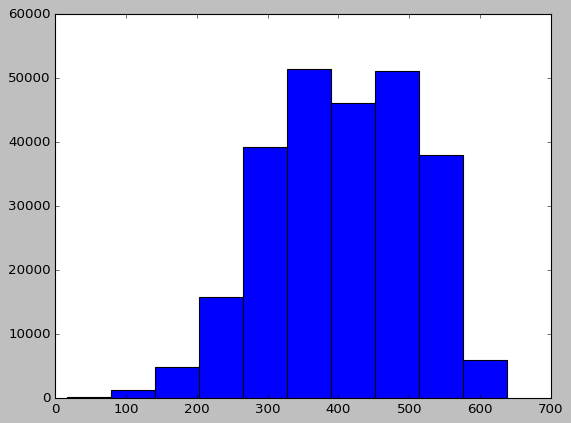

In [12]:
print(test_eflagged_rad.mean())
print(test_eflagged_rad.min())
print(test_eflagged_rad.max())
plt.hist(test_eflagged_rad)

(253270, 40, 40, 38)
(253270, 1, 3)
23.558098
149.60132


(array([3.039762e+06, 1.520000e+02, 4.900000e+01, 2.000000e+01,
        1.100000e+01, 3.000000e+00, 1.000000e+00, 1.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([   0.     ,  109.93297,  219.86594,  329.79892,  439.73187,
         549.66486,  659.59784,  769.5308 ,  879.46375,  989.3967 ,
        1099.3297 ], dtype=float32),
 <a list of 10 Patch objects>)

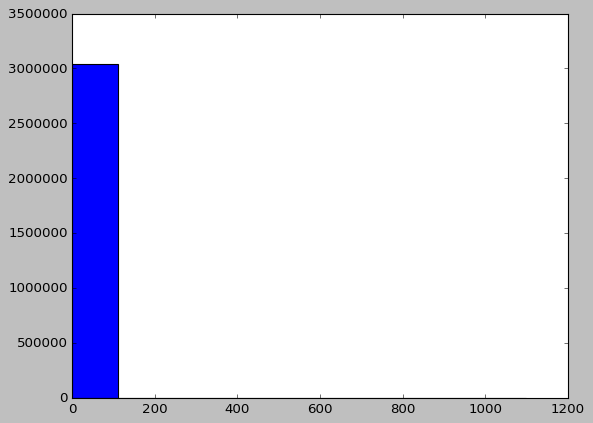

In [8]:
print(test_eflagged.shape)
print(test_eflagged_pos.shape)
print(test_eflagged.mean())
print(test_eflagged.std())
plt.hist(test_eflagged[:100,:,:,:19].flatten())

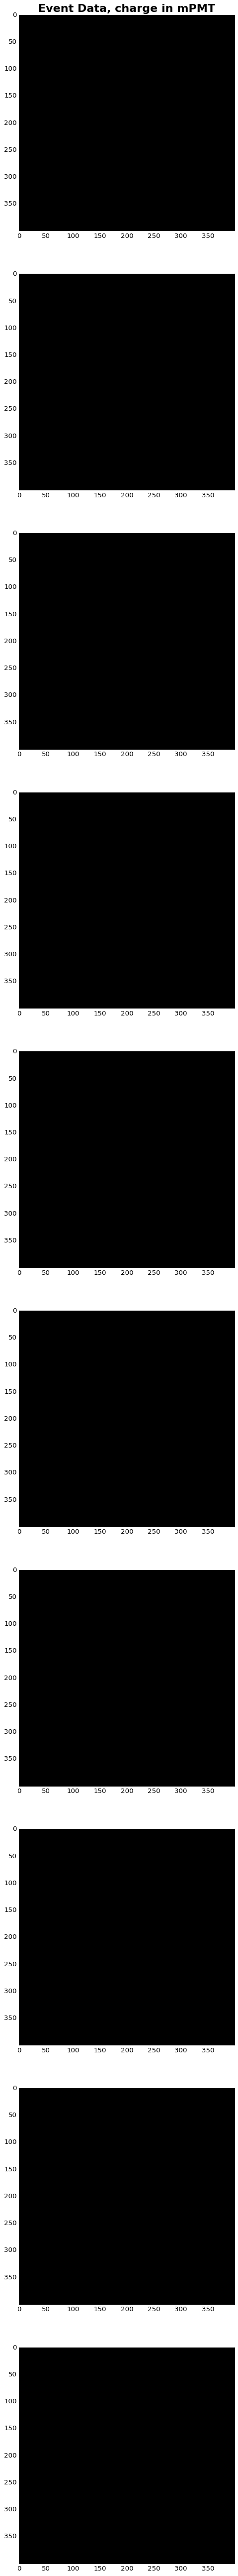

[142814, 101395, 32242, 130551, 209483, 249304, 38751, 85311, 36754, 46663]


'\nb = event_data([max_train_ind,:,:,0:19])\nb = np.ma.masked_where(b < 0.05, b)\nb[:,0:12, 14:26]\nb[:,28:40, 14:26]\n'

In [12]:
#fig, ax = plt.subplots(figsize=(16,8),facecolor='w')
fig, ax = plt.subplots(10, figsize=(160,80), facecolor='w')
cmap = plt.cm.afmhot
cmap.set_bad(color='black')
keys = []
for i in np.arange(10):
    
    k = random.randrange (0, test_eflagged.shape[0], 1)
    keys.append(k)
    a=PlottingEventDisplays.get_plot_array(test_eflagged[k,:,:,0:19])
    a = np.ma.masked_where(a < 0.05, a)
    ax[i].imshow(a,
               origin="upper",
               cmap=cmap,
               norm=colors.LogNorm(vmax=np.amax(test_eflagged[k,:,:,0:19])))
               #                               clip=True))

ax[0].set_title('Event Data, charge in mPMT',fontsize=20,fontweight='bold')

plt.show()
print(keys)
'''
b = event_data([max_train_ind,:,:,0:19])
b = np.ma.masked_where(b < 0.05, b)
b[:,0:12, 14:26]
b[:,28:40, 14:26]
'''